In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler



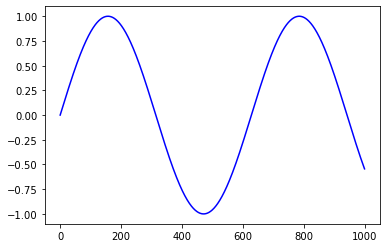

In [7]:
## 原始数据
index_ = torch.linspace(0,10,1000,dtype=torch.float32)
x = torch.sin(index_).type_as(index_)


plt.figure()
plt.plot(x, color="b", label="Actual")

plt.show()


In [8]:
## 序列数据
sequence_len = 30
featureNum = 1
train_x = torch.zeros(len(x)-sequence_len-1,sequence_len,featureNum,dtype=torch.float32)
train_y = torch.zeros(len(x)-sequence_len-1,1,dtype=torch.float32)
for i in range(sequence_len,len(x)-1):
    train_x[i-sequence_len,:,:] = x[i-sequence_len:i].reshape_as(train_x[0])
    train_y[i-sequence_len] = x[i+1]




In [9]:
i = 0
train_x[i,:],train_y[i]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900],
         [0.0999],
         [0.1099],
         [0.1198],
         [0.1298],
         [0.1397],
         [0.1496],
         [0.1595],
         [0.1694],
         [0.1792],
         [0.1890],
         [0.1989],
         [0.2087],
         [0.2184],
         [0.2282],
         [0.2379],
         [0.2476],
         [0.2573],
         [0.2670],
         [0.2766],
         [0.2862]]),
 tensor([0.3054]))

In [10]:
## 构造 batch
batch_size = 32
train_data = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



In [11]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)

    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


In [12]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1/5 Done, Total Loss: 0.07245417813925693
Time Elapsed for Epoch: 7.9140502 seconds
Epoch 2/5 Done, Total Loss: 0.0034605328653318185
Time Elapsed for Epoch: 9.0106754 seconds
Epoch 3/5 Done, Total Loss: 0.0014832142119606336
Time Elapsed for Epoch: 5.756950199999999 seconds
Epoch 4/5 Done, Total Loss: 0.0010890933976043017
Time Elapsed for Epoch: 5.658722299999997 seconds
Epoch 5/5 Done, Total Loss: 0.000944805998976032
Time Elapsed for Epoch: 5.577793100000001 seconds
Total Training Time: 33.918191199999995 seconds


Evaluation Time: 9.454082499999998
sMAPE: 0.12298412839684802%


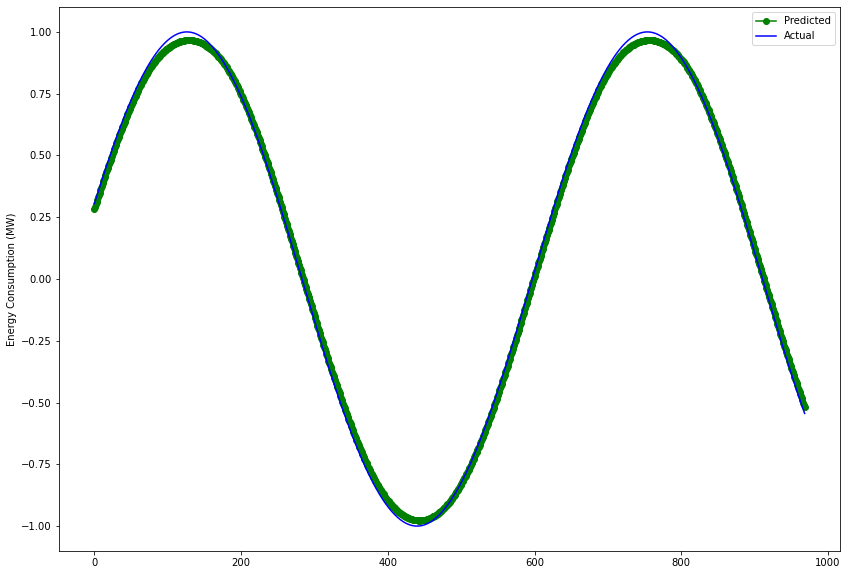

In [13]:

def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    for i in range(0,test_x.shape[0]):
        inp = test_x[i,:,:].reshape(1,test_x.shape[1],test_x.shape[2])
        labs = test_y[i]
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(out.detach().numpy().reshape(-1))
        targets.append(labs.numpy())
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE


test_range = 0
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, train_x[test_range:,:,:], train_y[test_range:])


## 显示效果
plt.figure(figsize=(14,10))
plt.plot(gru_outputs, "-o", color="g", label="Predicted")
plt.plot(targets, color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.show()